# Simple Implementation of Variational Autoencoder 

This implementation uses a simple convolutional autoencoder with a bottleneck layer trained as a latent variable vector. The ELBO loss used to train the network has the following form:

$$ 
ELBO=\mathbb{E}_{z\sim q}log(p_\theta(x|z)) - \beta*\mathbb{E}_{z\sim q}\frac{log(q_\psi(z|x))}{log(p_{\theta}(z)}
$$

Additionally the `beta` coefficient is introduced in order to balance KL and reconstruction components of the loss function. Without proper adjustment of `beta` the trained network degrades in either of two states:
- degraded latent variable very close to `N(0, 1)` which makes correct reconstruction impossible 
- unstructured latent space very far from `N(0, 1)` which makes exploration of latent space very difficult. 

## See also
For more information on variational autoencoders see:
* [Variational Autoencoder Demystified With PyTorch Implementation](https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed) by William Falcon with lots of inline explanations. 
* [Reparametrization Trick](https://www.youtube.com/watch?v=nKM9875PVtU) clearly explained by Kapil Sachdeva
* [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) - the original paper inroducing the method. 


In [1]:
import matplotlib.pyplot as plt
import torch as th
import torchvision as tv
from torch.nn import Conv2d, ReLU, Sequential, MaxPool2d, Flatten, Linear, LogSoftmax, SiLU
from torch.distributions import Normal
from torch.nn import ConvTranspose2d, BatchNorm2d, Tanh


BATCH_SIZE = 64
DEBUG = False
BETA = 5
EPOCHS = 5

In [2]:
transform = (tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5,), (0.5,))]))

trainset = tv.datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
testset = tv.datasets.MNIST('mnist_test', train=False, download=True, transform=transform)

trainloader = th.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = th.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
class AutoEncoderModule(th.nn.Module):

    def encoder(self, x):
        x = self.encoder_conv(x)
        mu = self.mu_encoder(x)
        sigma = self.sigma_encoder(x)
        sigma = th.exp(sigma / 2)
        return Normal(mu, sigma)

    def decoder(self, z):
        x = z.rsample()
        x = x.unsqueeze(2).unsqueeze(3)
        x = self.decoder_conv(x)
        return x

    def __init__(self):
        super().__init__()

        self.encoder_conv = Sequential(
            Conv2d(1, 5, 3, stride=2, padding=1), # 1x28x28 -> 5x14x14
            BatchNorm2d(5),
            SiLU(),
            Conv2d(5, 10, 3, stride=2, padding=1), # 5x14x14 -> 10x7x7
            BatchNorm2d(10),
            SiLU(),
            Conv2d(10, 20, 7), # 10x7x7 -> 30x1x1
            BatchNorm2d(20),
            SiLU(),
            Flatten(1)
        )
        self.mu_encoder = th.nn.Linear(20, 10)
        self.sigma_encoder = th.nn.Linear(20, 10)

        self.decoder_conv = Sequential(
            ConvTranspose2d(10, 10, 7),
            BatchNorm2d(10),
            SiLU(),
            ConvTranspose2d(10, 5, 3, stride=2, padding=1, output_padding=1),
            BatchNorm2d(5),
            SiLU(),
            ConvTranspose2d(5, 1, 3, stride=2, padding=1, output_padding=1),
            BatchNorm2d(1),
            Tanh(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z


# Training

In [4]:
import numpy as np
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.nn import MSELoss

auto_encoder = AutoEncoderModule()
device = 'cuda' if th.cuda.is_available() else 'cpu'

auto_encoder.to(device)

loss = MSELoss(reduction='none')
optimizer = Adam(auto_encoder.parameters())


def gen_total_loss(data, y, z, beta):
    reconstruct_loss = loss(y_pred, data).sum((-1, -2, -3))
    kl_divergence = th.distributions.kl_divergence(q, Normal(th.zeros_like(q.loc), th.ones_like(q.scale))).sum(-1) * beta
    loss_value = (reconstruct_loss + kl_divergence).mean()
    return loss_value, kl_divergence, reconstruct_loss


for epoch in range(EPOCHS):
    auto_encoder.train()
    train_loader = tqdm(trainloader)
    for data, _ in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        y_pred, q = auto_encoder(data)
        loss_value, kl_divergence, reconstruct_loss = gen_total_loss(data, y_pred, q, BETA)        
        train_loader.set_description(f'Epoch {epoch}, train loss: {loss_value.item():.02f}. kl:{kl_divergence.mean().item():.02f} reconstruct:{reconstruct_loss.mean().item():.02f}')
        loss_value.backward()
        optimizer.step()
        if DEBUG:
          break
    with th.no_grad():
        auto_encoder.eval()
        losses = []
        test_loader = tqdm(testloader)
        for data, _ in test_loader:
            data = data.to(device)
            y_pred, q = auto_encoder(data)
            loss_value, kl_divergence, reconstruct_loss = gen_total_loss(data, y_pred, q, BETA)
            losses.append(loss_value.cpu())
            test_loader.set_description(f'Epoch {epoch}, train loss: {loss_value.item():.02f}. kl:{kl_divergence.mean().item():.02f} reconstruct:{reconstruct_loss.mean().item():.02f}')
            if DEBUG:
              break

        print(f'eval loss {np.mean(losses):.02f}', )
    if DEBUG:
      break


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

eval loss 194.51


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

eval loss 164.79


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

eval loss 153.42


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

eval loss 148.05


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

eval loss 145.26


# Evaluation

## Reconstruction of data samples

Reconstruction is a bit blurry as expected from a VAE

  0%|          | 0/157 [00:00<?, ?it/s]

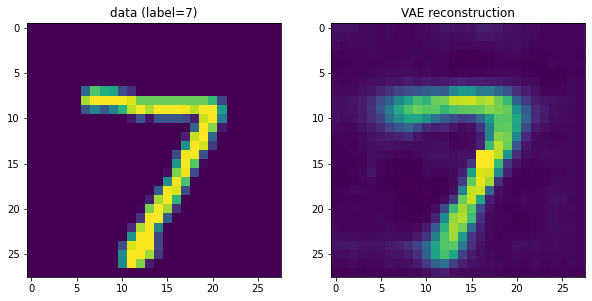

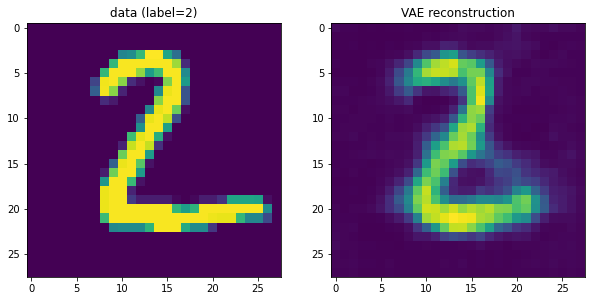

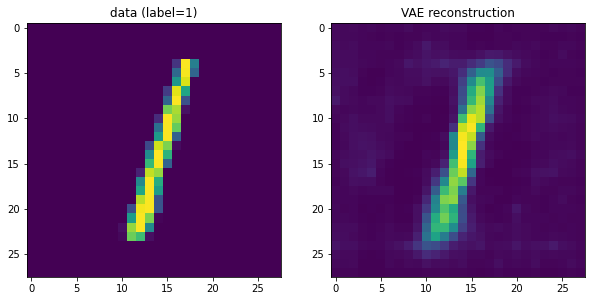

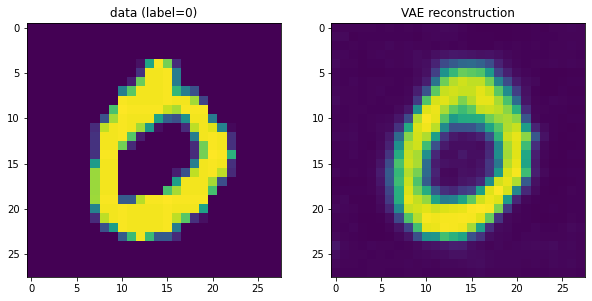

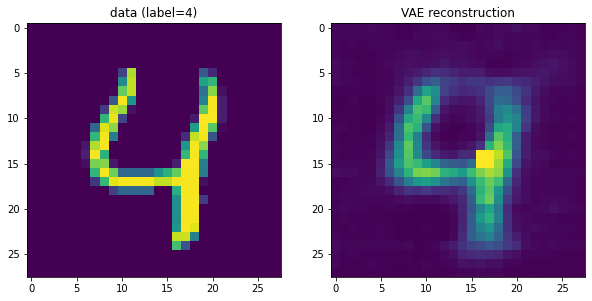

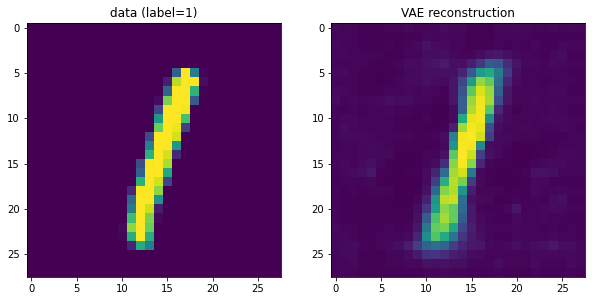

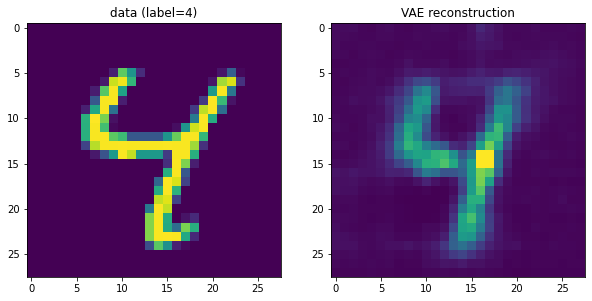

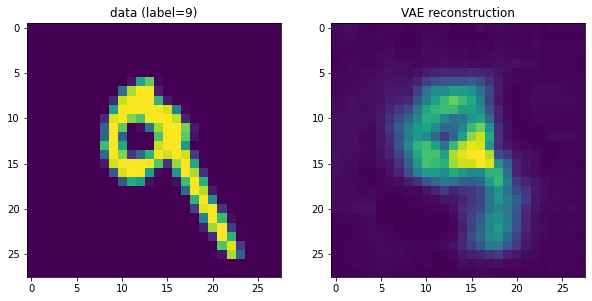

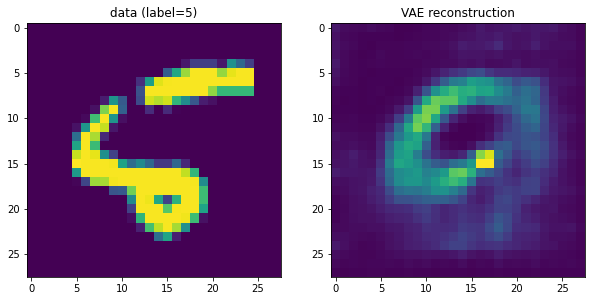

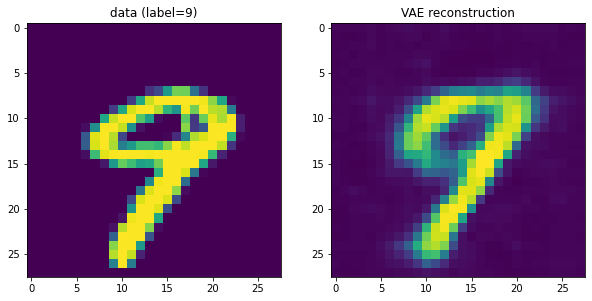

In [5]:
with th.no_grad():
    auto_encoder.eval()
    for data, labels in tqdm(testloader):
        data = data.to(device)
        z = auto_encoder(data)[1]
        z.scale = (th.ones(len(z.loc[1])) * 1e-6).to(device)  # ~0 std to slightly improve reconstruction quality
        pred = auto_encoder.decoder(z)
        for i in range(10):
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(data[i][0].cpu())
            axs[0].set_title(f'data (label={labels[i].item()})')
            axs[1].imshow(pred[i][0].cpu())
            axs[1].set_title(f'VAE reconstruction')
        break


## Exploration of the latent space

/var/folders/72/6hfzgnzn33n1q5y_d422yv8h0000gp/T/ipykernel_36849/1924807807.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 10, figsize=(20, 3))


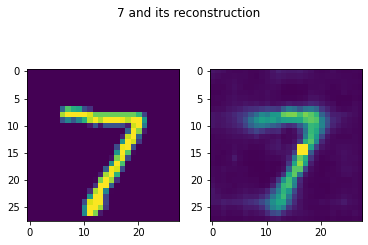

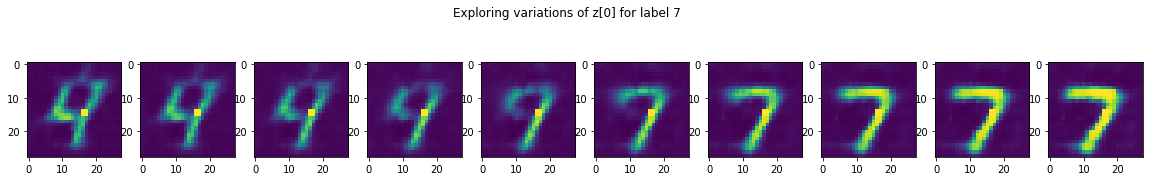

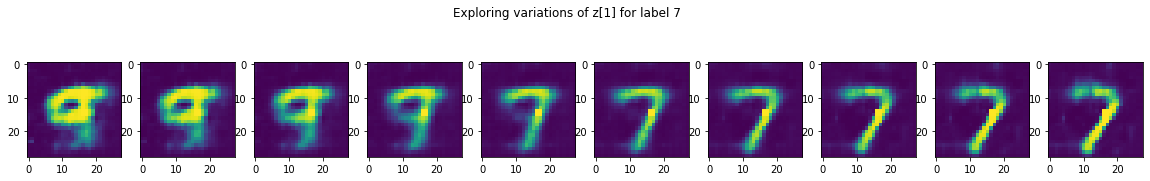

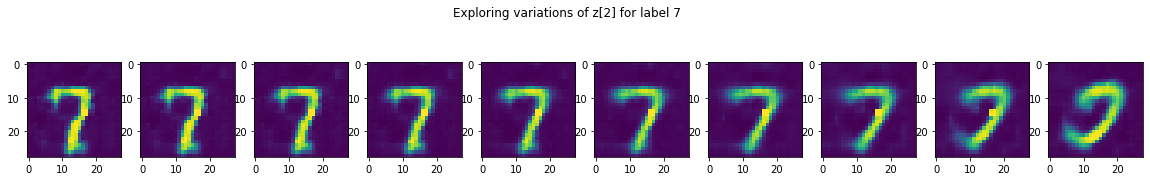

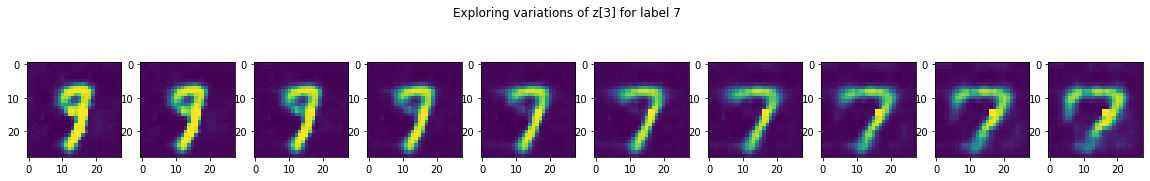

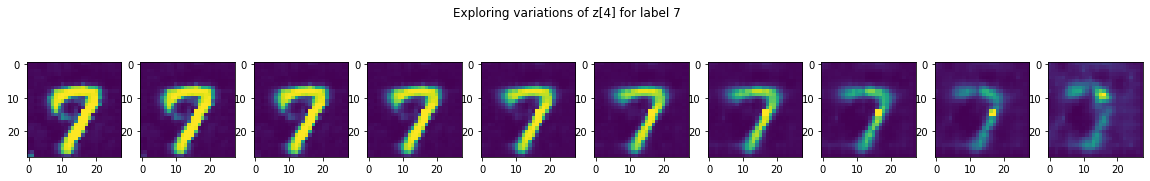

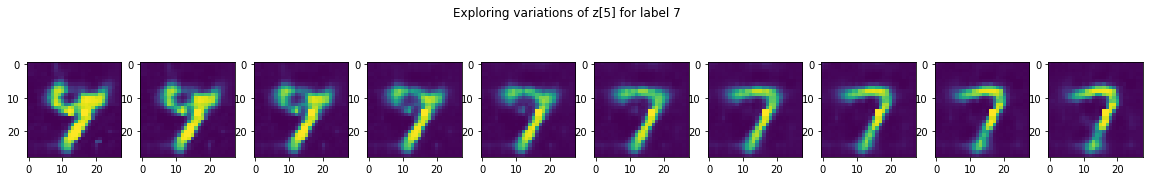

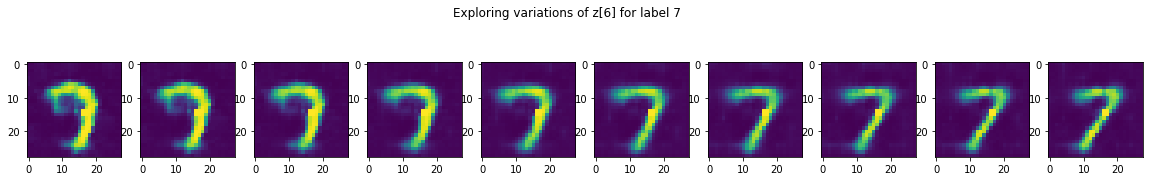

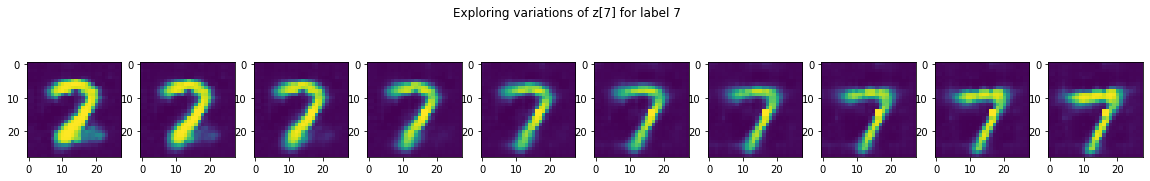

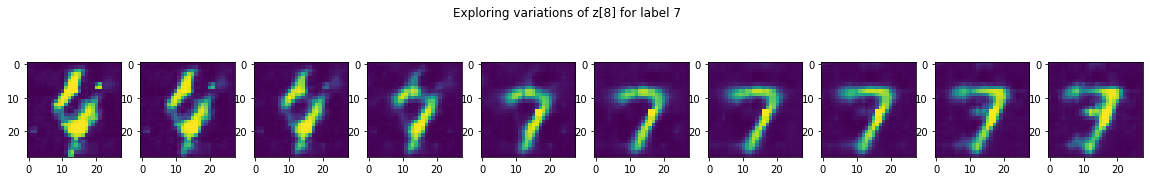

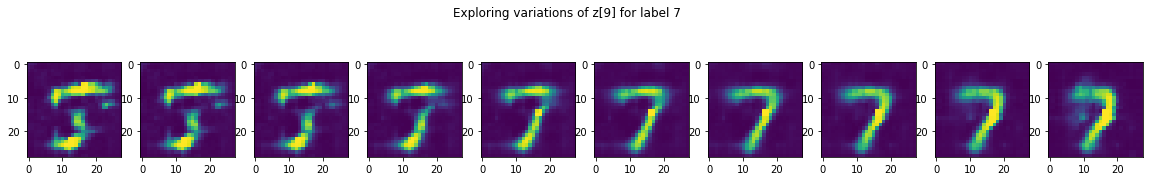

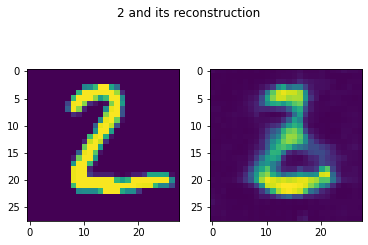

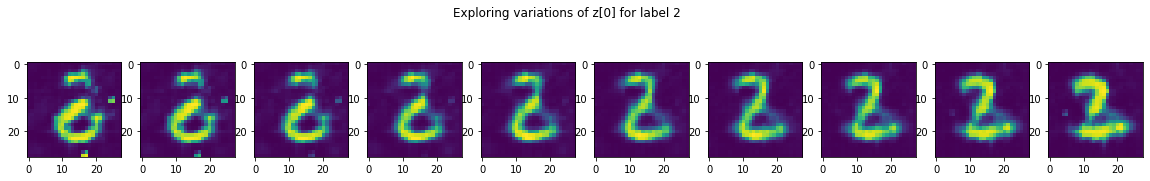

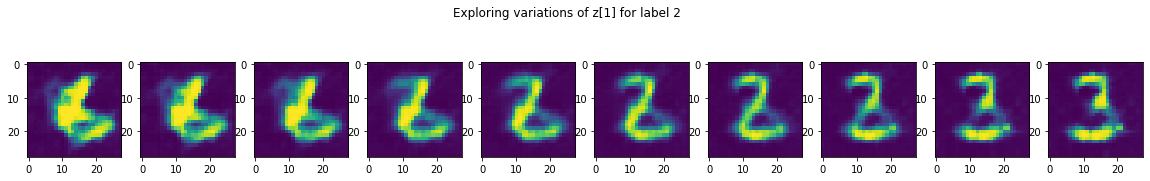

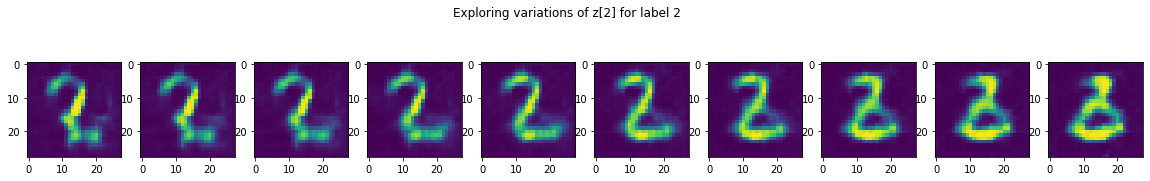

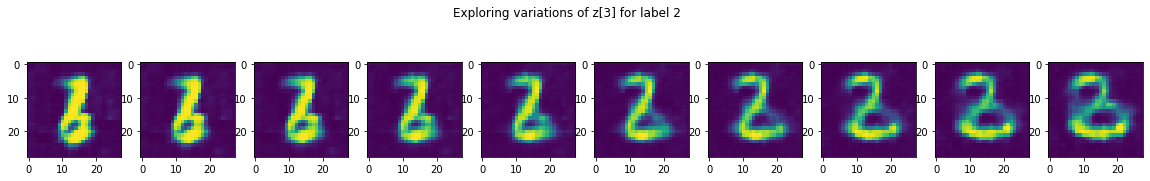

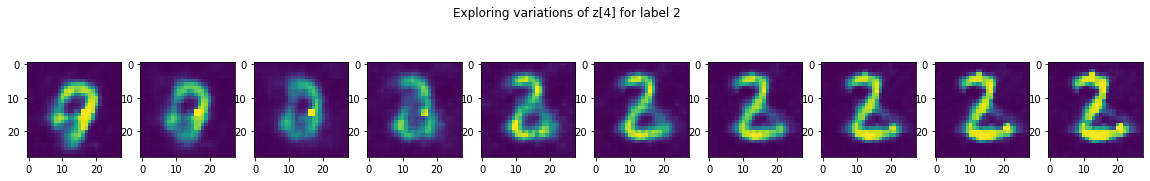

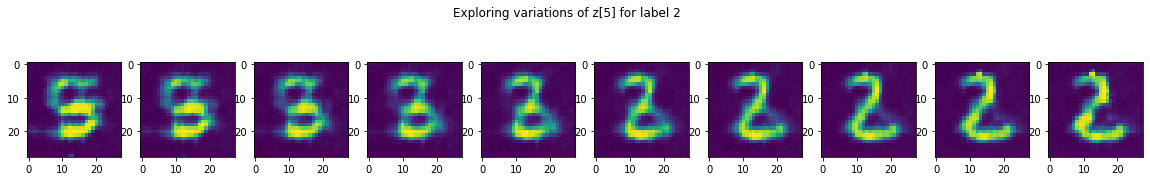

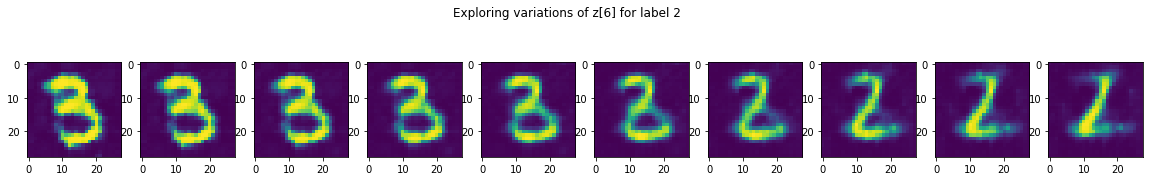

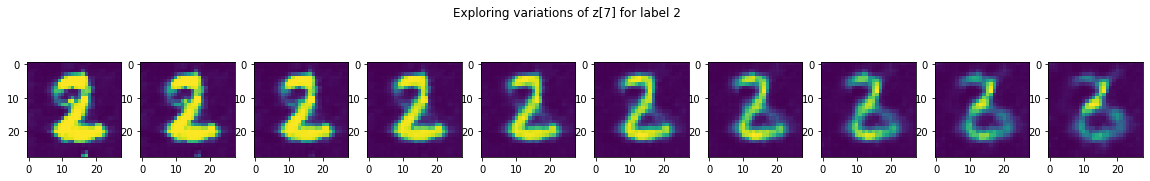

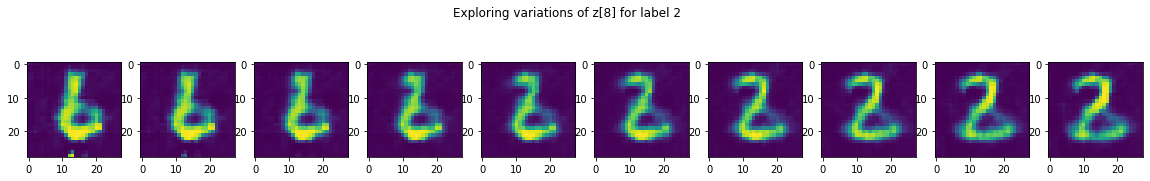

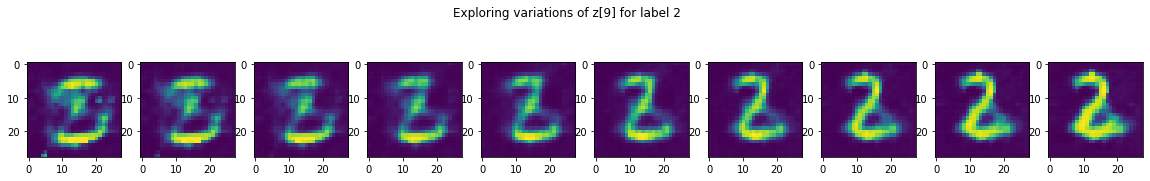

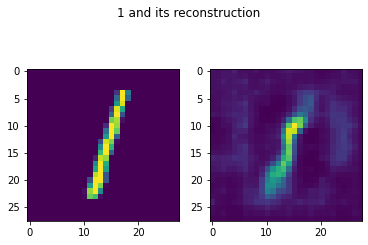

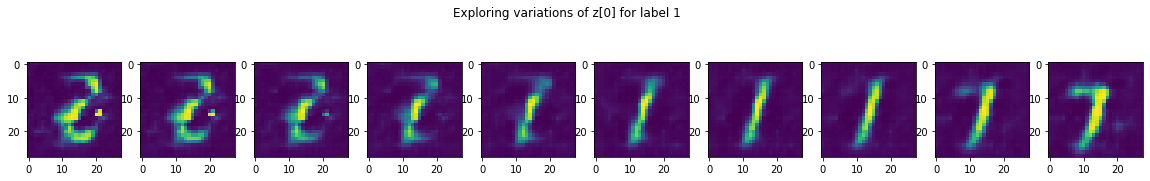

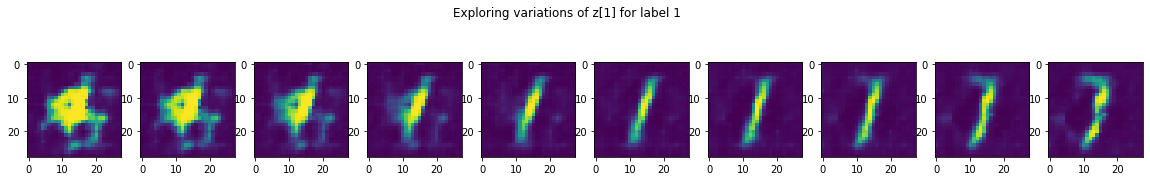

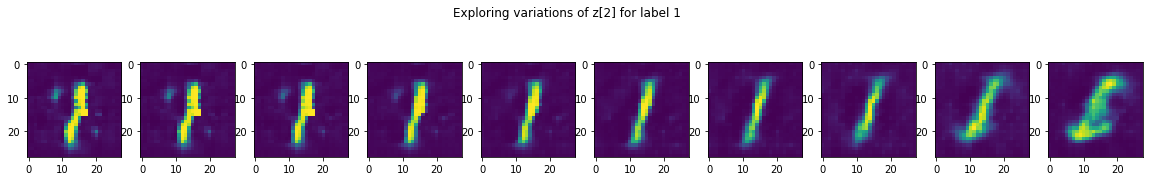

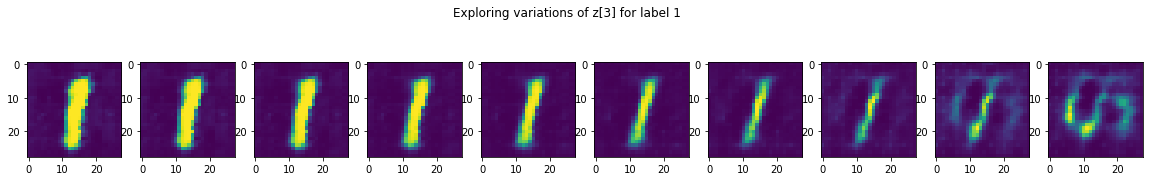

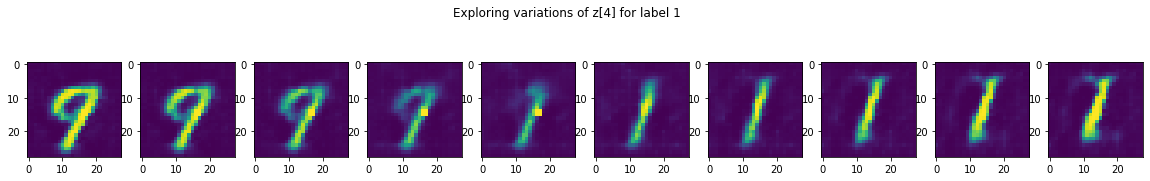

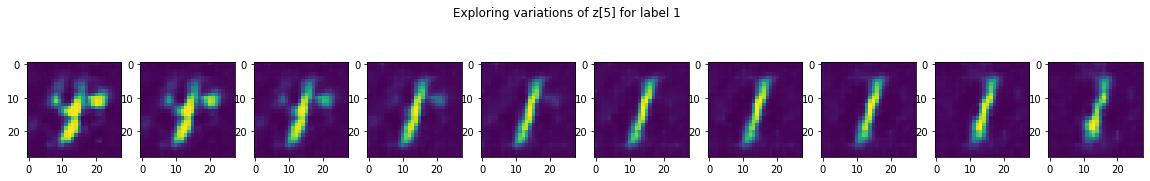

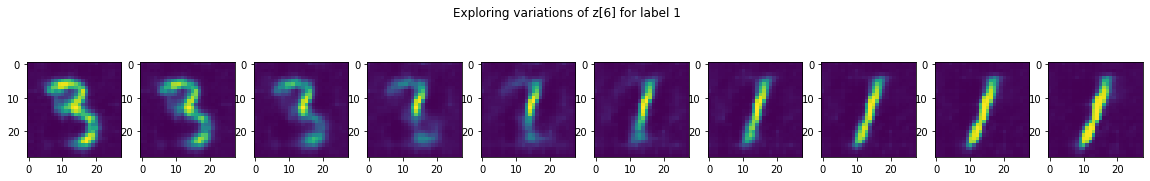

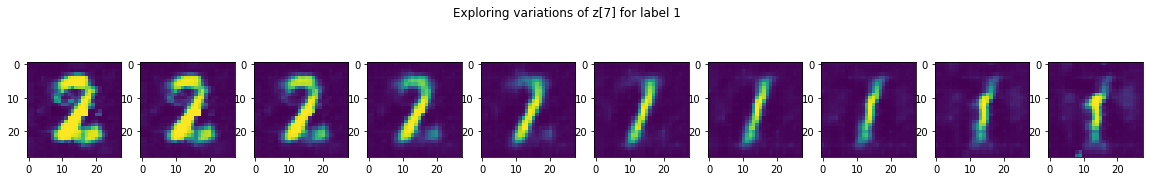

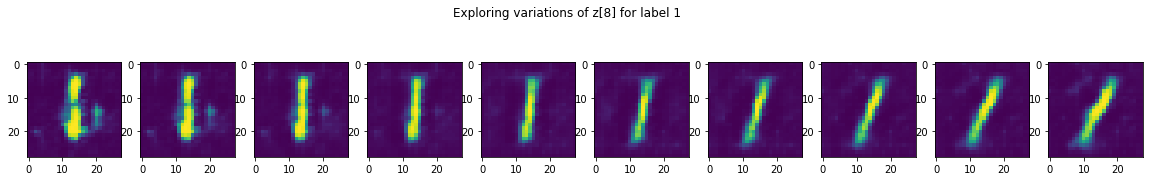

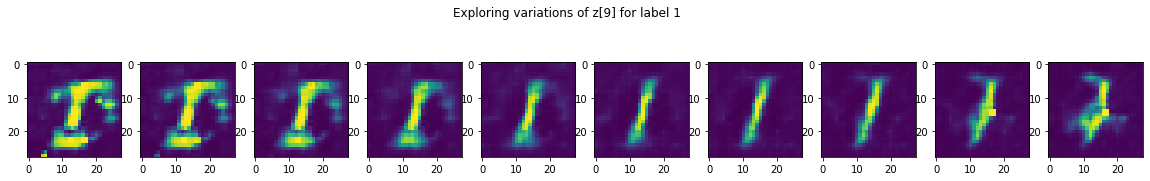

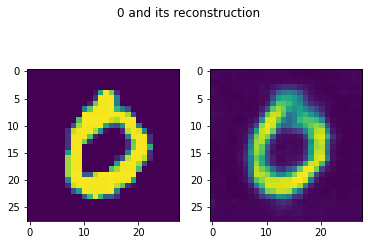

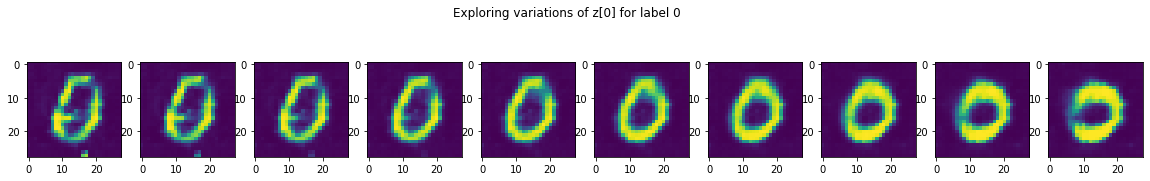

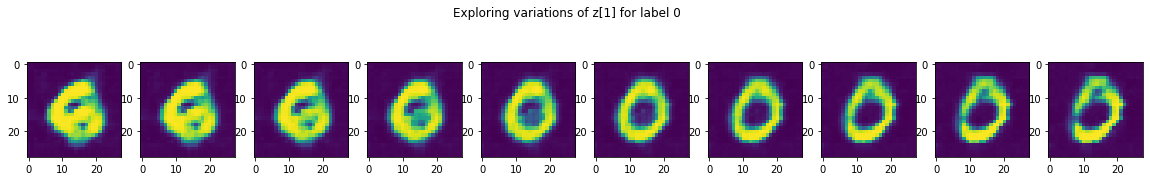

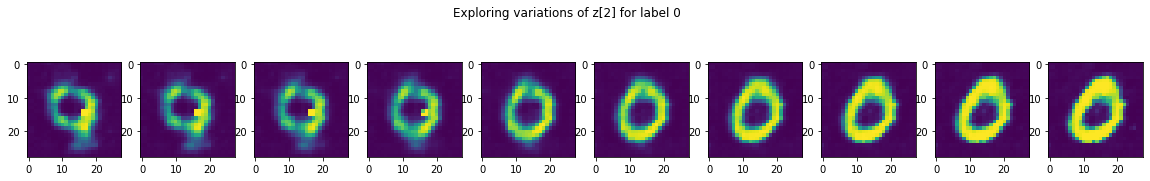

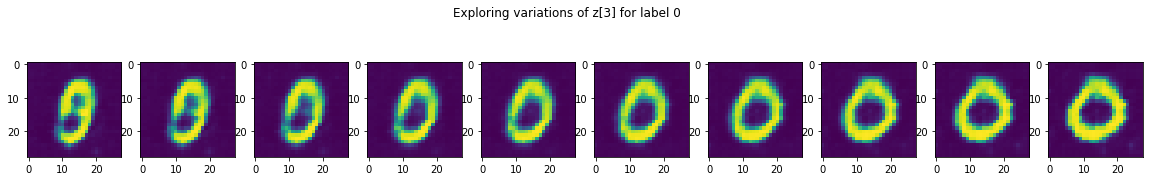

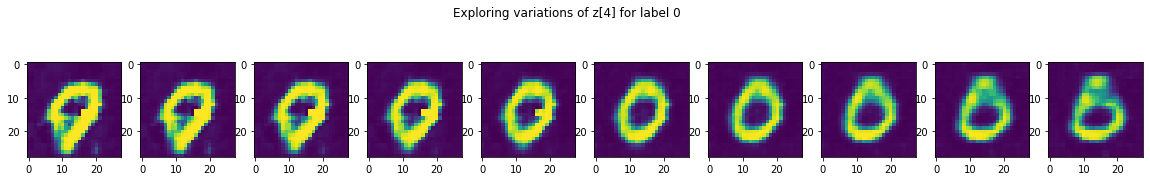

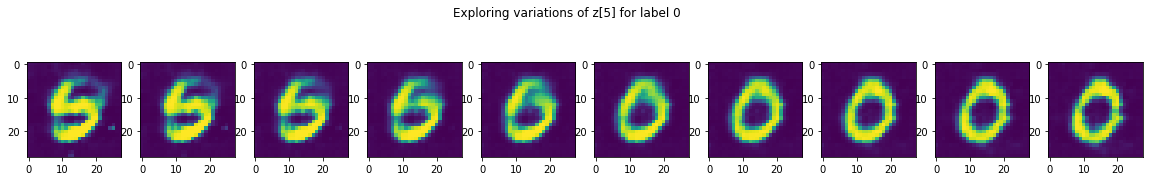

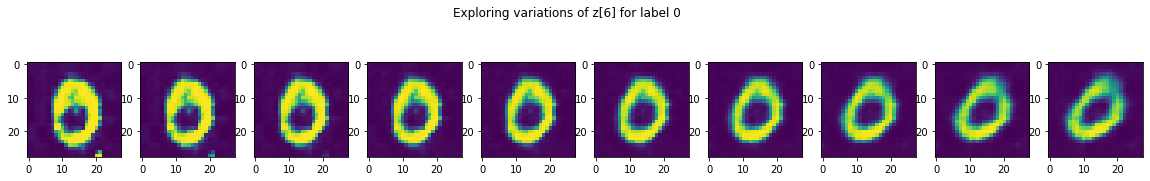

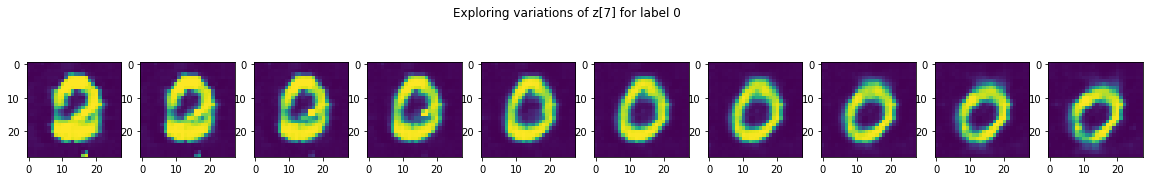

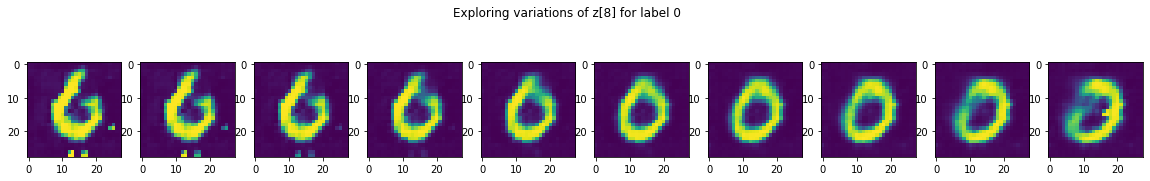

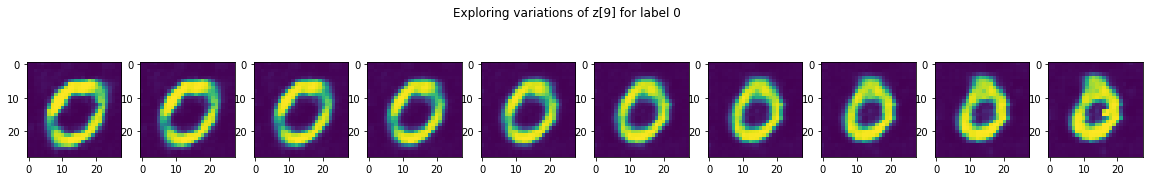

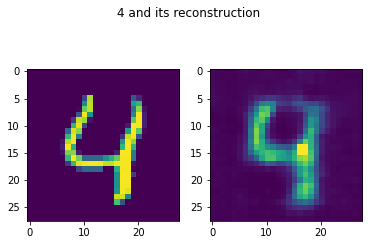

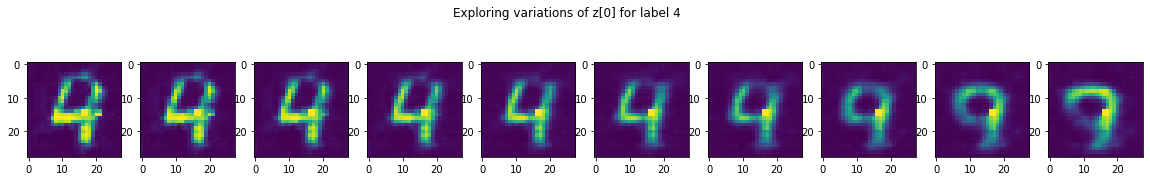

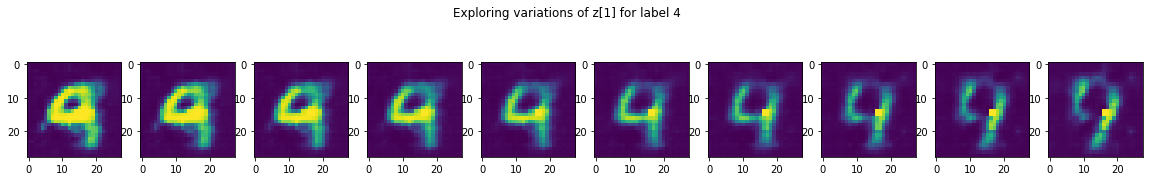

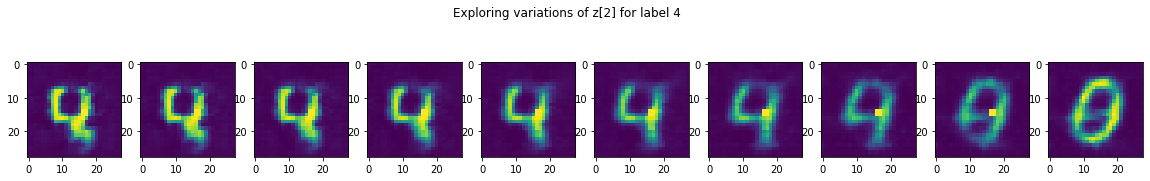

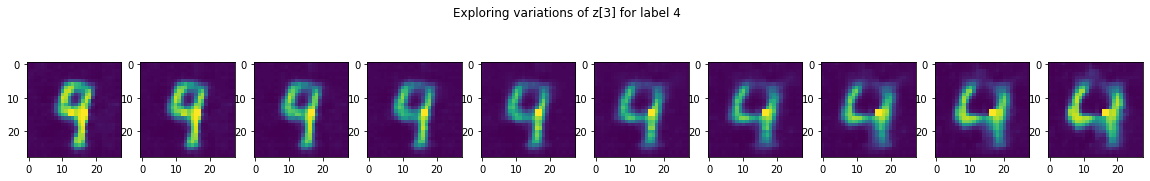

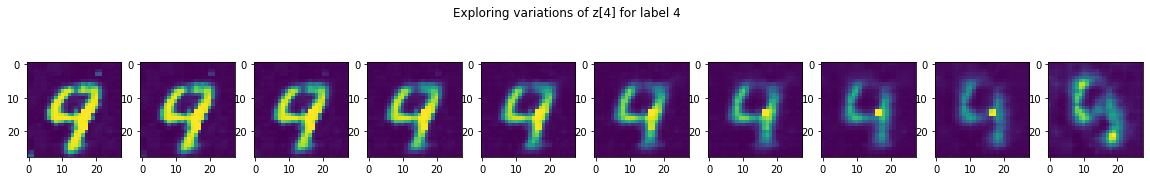

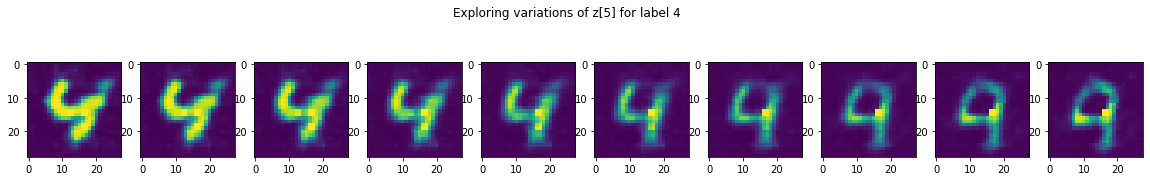

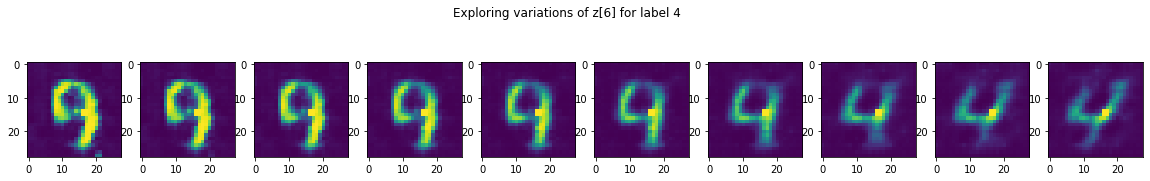

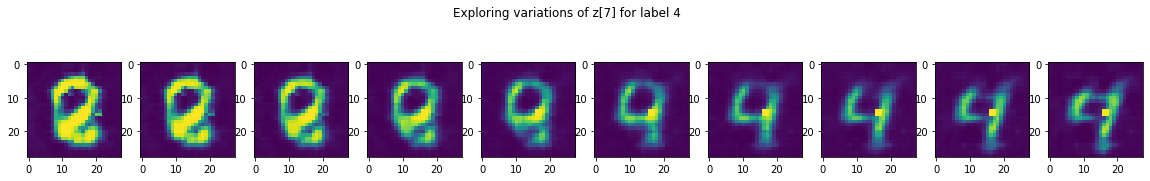

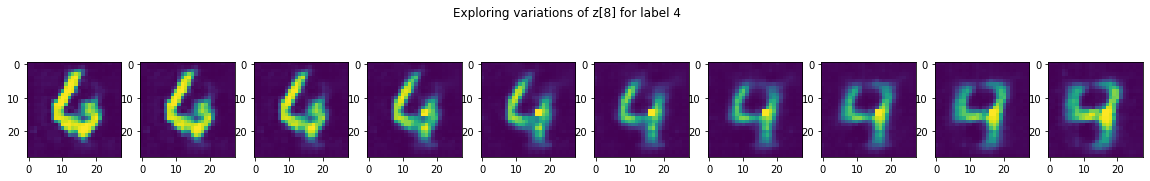

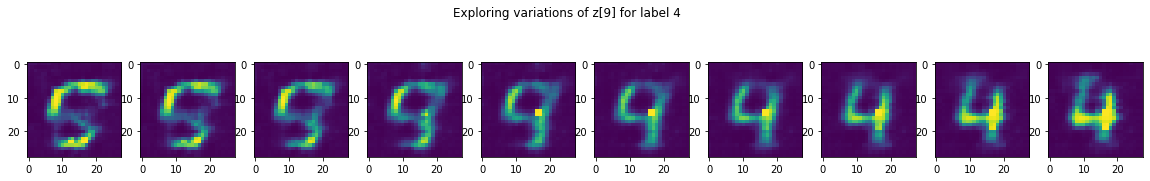

In [6]:
with th.no_grad():
    for data, labels in testloader:
        for im in range(5):
            
            y, z = auto_encoder(data.to(device))
            fig, axs = plt.subplots(1, 2)
            fig.suptitle(f'{labels[im]} and its reconstruction')
            axs[0].imshow(data[im][0].cpu())
            axs[1].imshow(y[im][0].cpu())

            loc, scale = z.loc[im], z.scale[im]
            for i in range(len(loc)):
                fig, axs = plt.subplots(1, 10, figsize=(20, 3))
                fig.suptitle(f'Exploring variations of z[{i}] for label {labels[im]}')
                for k in range(10):
                    mu = th.clone(loc)
                    scaler = 12
                    mu[i] += (-scaler + 2 * k * scaler / scaler) * scale[i]
                    norm = th.distributions.Normal(mu.unsqueeze(0).to(device), th.tensor([1e-6] * 10).unsqueeze(0).to(device))
                    y = auto_encoder.decoder(norm)[0]
                    axs[k].imshow(y.reshape(-1, 28).cpu())
        break
